## Lista 04 - Visão Computacional - Matheus Carvalho

### Bibliotecas Usadas

In [169]:
import soundfile as sf
import matplotlib.pyplot as plt
import numpy as np
import cv2
from scipy.io import wavfile

### Questão 01

#### Item A

In [170]:
# carrega o audio e obtem os dados do audio e a taxa de amostragem/segundo
audio_data, sample_rate = sf.read("audios/StarWars60.wav")
# calcula o número de amostrar necessárias para 10 segundos
amostras_desejadas = 10 * sample_rate
# seleciona as primeiras amostrar para reduzir o áudio para 10 segundos
audio_10s = audio_data[:amostras_desejadas]

#### Item B 

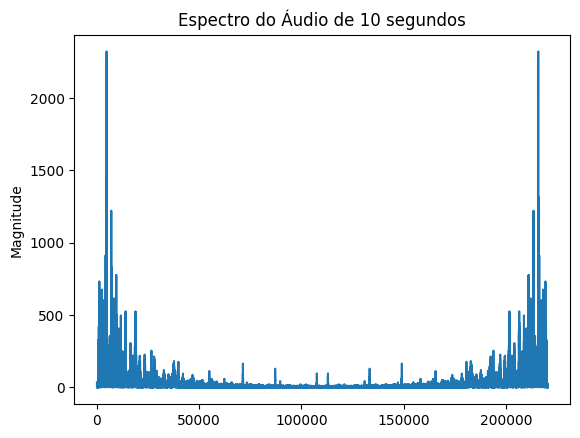

In [171]:
# aplica a transformada de fourier
transformada_de_fourier = np.fft.fft(audio_10s)

# apenas pega o valor absoluto
spectrum = np.abs(transformada_de_fourier)

# plota o espectograma
plt.plot(spectrum)
plt.ylabel('Magnitude')
plt.title('Espectro do Áudio de 10 segundos')
plt.show()


### Questão 02

#### Item A

In [172]:
def compressao_fourier(path_audio:str="audios/StarWars60.wav", percentual:float=0.8, to_save:bool=False):
    """
    Comprime um arquivo de áudio aplicando a transformação de Fourier.

    Parâmetros:
        path_audio (str): O caminho para o arquivo de áudio a ser comprimido. Por padrão, é "StarWars60.wav".
        percentual (float): O percentual das frequências baixas a serem preservadas, variando de 0 a 1. Por padrão, é 0.8.
        to_save (bool): Indica se o áudio compactado deve ser salvo em um arquivo. Por padrão, é False.

    Retorna:
        tuple: Uma tupla contendo o sinal de áudio compactado e a taxa de amostragem.

    Exemplo:
        audio_compactado, taxa_amostragem = compressao_fourier("audio.wav", 0.8)
    """

    # carrega o áudio
    audio_data, sample_rate = sf.read(path_audio)
    
    # aplica a transformação de fourier 
    sinal_fft = np.fft.fft(audio_data)
    
    # pega o número de amostra
    num_amostras = len(sinal_fft)
    
    # determina quantas amostras vão ser preservadas
    num_preservadas = int(num_amostras * percentual)
    
    # todas as outras amostrar são zeradas
    sinal_fft[num_preservadas:] = 0
    
    # aplica a transformação inversa para obter o sinal compacto
    sinal_compactado = np.fft.ifft(sinal_fft).real

    if to_save:
        sf.write(f"COMP_{path_audio.split("/")[-1]}", sinal_compactado, sample_rate)
    
    return sinal_compactado, sample_rate

In [173]:
sinal_comp, samp_rate = compressao_fourier(to_save=False)

#### Item B

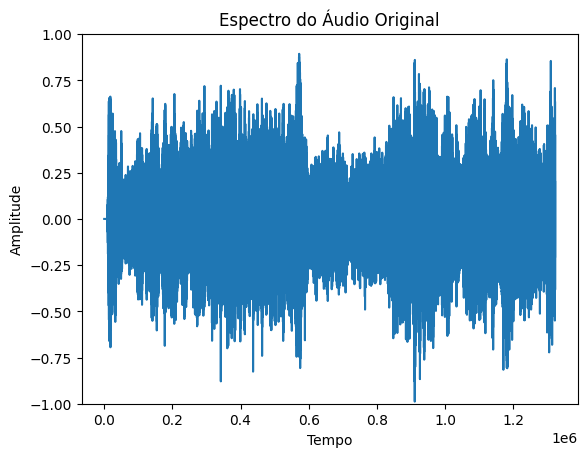

In [174]:
# plota o espectograma
plt.plot(audio_data)
plt.xlabel('Tempo')
plt.ylabel('Amplitude')
plt.title('Espectro do Áudio Original')
plt.ylim(-1, 1)
plt.show()

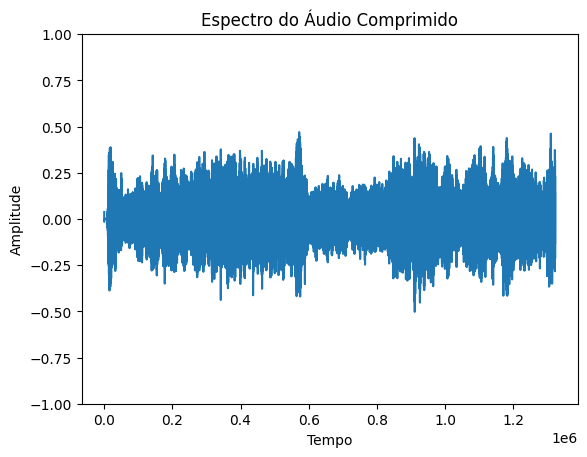

In [175]:
# plota o espectograma
plt.plot(sinal_comp)
plt.xlabel('Tempo')
plt.ylabel('Amplitude')
plt.title('Espectro do Áudio Comprimido')
plt.ylim(-1, 1)
plt.show()

Ouvindo os áudios, não consegui notar nenhuma grande diferença. Porém, pensei em plotar o espectograma para conseguir ver o que estava acontecendo. Um resultado que é facilmente notável, é que a amplitude dos dois áudios, ou seja, a intensidade da onda sonora, diminuiu após a compressão de Fourier. 

### Questão 03

fonte (só inspiração): https://www.youtube.com/watch?v=_xxIJViPwOQ

fonte principal: https://gormatevosyan.com/convolutional-reverb-how-and-why-does-it-work/

### Item A

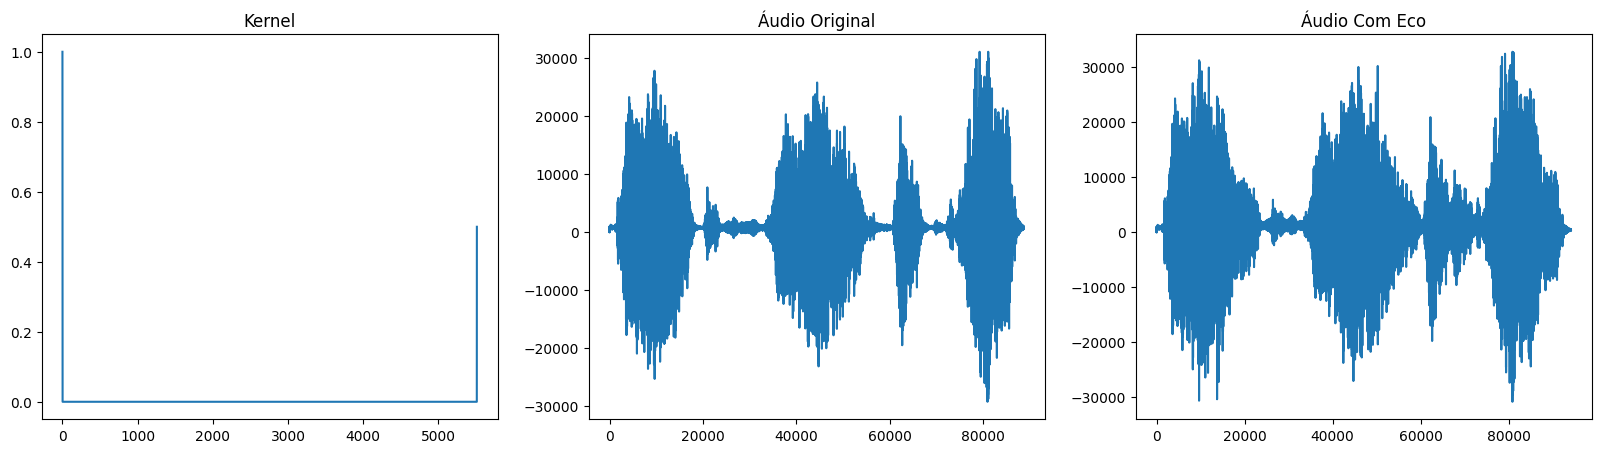

In [176]:
# vou carregar o arquivo de áudio
sample_rate, audio_data = wavfile.read('audios/Leao.WAV')

# definir o tamanho do Kernel (para um eco de 0.5 segundos) e o ganho
eco_delay = int(0.5 * sample_rate) 
eco_gain = 0.5 

# cria o array do kernel
kernel = np.zeros(eco_delay)
kernel[0] = 1
kernel[-1] = eco_gain

# tava tendo um problema com a dimensão do arquivo de áudio
if audio_data.ndim > 1:
    audio_data = np.mean(audio_data, axis=1)

# aplica a convolução
audio_eco = np.convolve(audio_data, kernel, mode='full')

# normalização para evitar que o áudio estoure (foi o que eu entendi)
audio_eco = np.int16(audio_eco / np.max(np.abs(audio_eco)) * 32767)

#salvo o áudio
wavfile.write('Leao_com_Eco.wav', sample_rate, audio_eco)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(kernel)
ax[0].set_title("Kernel")
ax[1].plot(audio_data)
ax[1].set_title("Áudio Original")
ax[2].plot(audio_eco)
ax[2].set_title("Áudio Com Eco")
plt.show()

#### Item B

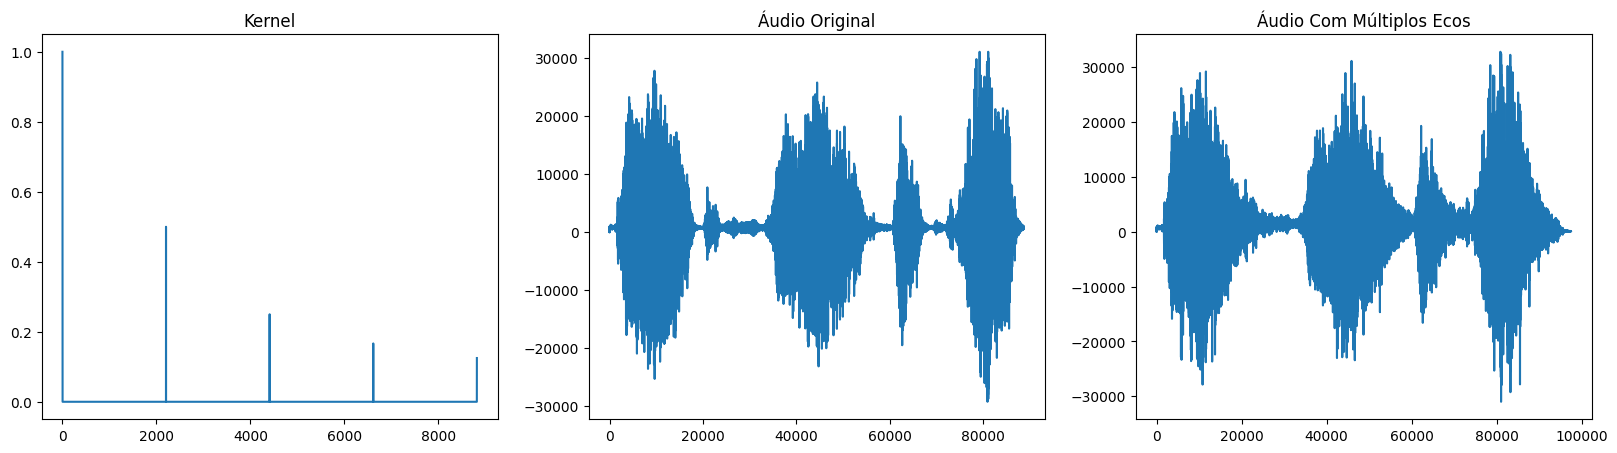

In [177]:
# diferença entre os ecos vai ser de 0.2 segundos
eco_delay = int(0.2 * sample_rate) 
eco_gain = 0.5 

kernel = np.zeros(eco_delay)
kernel[0] = 1
kernel[-1] = eco_gain

# a grande diferença estar em criar um kernel com multiplos picos
for i in range(2, 5):
    kernel_aux = np.zeros(eco_delay)
    kernel_aux[-1] = eco_gain/i
    kernel = np.hstack([kernel, kernel_aux])

# aplica a convolução
audio_eco = np.convolve(audio_data, kernel, mode='full')

# normalização para evitar que o áudio estoure (foi o que eu entendi)
audio_eco = np.int16(audio_eco / np.max(np.abs(audio_eco)) * 32767)

#salvo o áudio
wavfile.write('Leao_com_Eco_eco_Eco_eco.wav', sample_rate, audio_eco)

fig, ax = plt.subplots(1, 3, figsize=(20, 5))

ax[0].plot(kernel)
ax[0].set_title("Kernel")
ax[1].plot(audio_data)
ax[1].set_title("Áudio Original")
ax[2].plot(audio_eco)
ax[2].set_title("Áudio Com Múltiplos Ecos")
plt.show()

### Questão 04

#### Item A

In [178]:
def filtro_passa(image_path:str="frutas.jpg", fraction:float=0.8, passa_alta:bool=False) -> np.ndarray:
    """
    Aplica um filtro passa-baixa ou passa-alta em uma imagem, dependendo do parâmetro passa_alta.

    Args:
        image_path (str): O caminho da imagem a ser filtrada. O padrão é "frutas.jpg".
        fraction (float): A fração das frequências a serem preservadas pelo filtro.
            Deve estar no intervalo [0,1]. O padrão é 0.8.
        passa_alta (bool): Se True, aplica um filtro passa-alta. Se False, aplica um filtro passa-baixa.
            O padrão é False.

    Returns:
        np.ndarray: A imagem filtrada.

    Exemplo:
        filtered_image = filtro_passa(image_path="exemplo.jpg", fraction=0.5, passa_alta=True)
    """
    # abre a imagem
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # aplica a transformada de Fourier (mais de uma dimensão)
    image_fft = np.fft.fft2(image) 
    # deslocamento do espectro (tinha feito a mesma coisa na questão 07)
    image_shift = np.fft.fftshift(image_fft)
    # tiro o valor absoluto
    espectro = np.abs(image_shift)
    # ordeno os valores (decrescente)
    espectro_ordenado = np.sort(espectro.flatten())[::-1]
    # apenas um truque para descobrir o índice do meu threshold
    threshold_index = int(fraction * len(espectro_ordenado))
    threshold = espectro_ordenado[threshold_index]
    # vai manter todos que forem menores que o treshhold
    if passa_alta:
        image_shift_filtered = image_shift * (espectro >= threshold)
    else:
        image_shift_filtered = image_shift * (espectro <= threshold)
    # inverto o deslocamento do espectro
    image_inv_shift = np.fft.ifftshift(image_shift_filtered)
    # inverto a transformada de Fourier
    image_filtered = np.fft.ifft2(image_inv_shift)
    # tiro novamente o módulo
    image_filtered = np.abs(image_filtered)

    return image_filtered

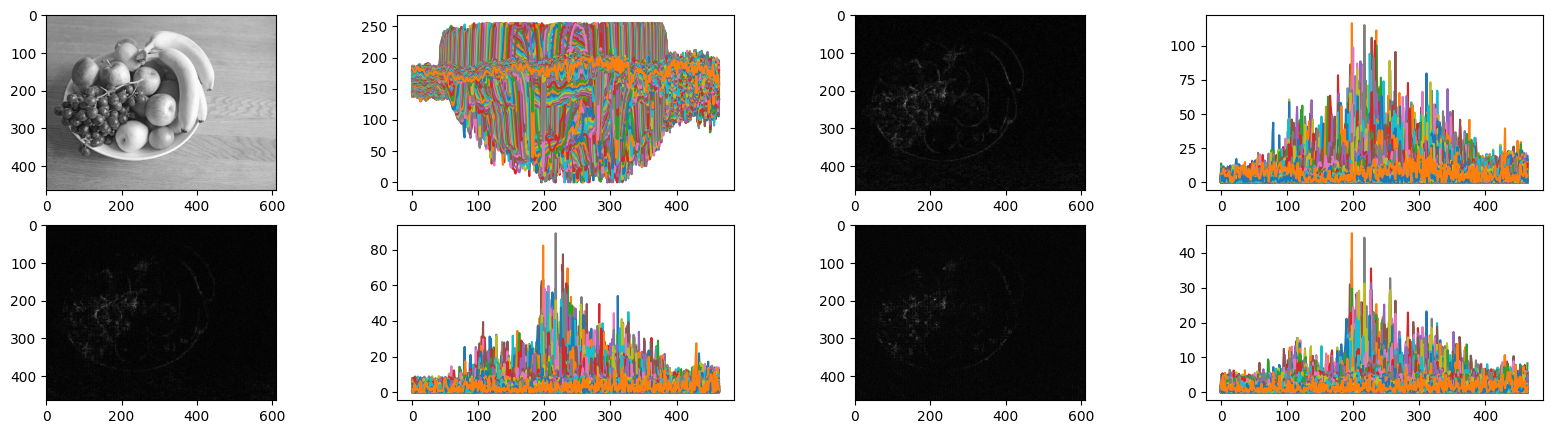

In [179]:
image = cv2.imread("frutas.jpg", cv2.IMREAD_GRAYSCALE)

fig, ax = plt.subplots(2, 4, figsize=(20, 5))
ax[0, 0].imshow(image, cmap='gray')
ax[0, 1].plot(image)
ax[0, 2].imshow(filtro_passa(fraction=0.10), cmap='gray');
ax[0, 3].plot(filtro_passa(fraction=0.10));
ax[1, 0].imshow(filtro_passa(fraction=0.25), cmap='gray');
ax[1, 1].plot(filtro_passa(fraction=0.25));
ax[1, 2].imshow(filtro_passa(fraction=0.50), cmap='gray');
ax[1, 3].plot(filtro_passa(fraction=0.50));

#### Item B

Podemos ver que à medida que mais frequências são descartadas, mas fica difícil de identificar a imagem. Em casos menos extremaos, como é o segundo caso, onde apenas as 10% maiores frequências foram descartadas, ainda conseguimos ver claramente os limites dos elementos das imagens. Qualquer coisa muito maior do que 10% já fica quase impossível. No gráfico criado acima, podemos notar que grande parte das grandes frquências vão se perdendo quando aumentamos o threshold.

#### Item C

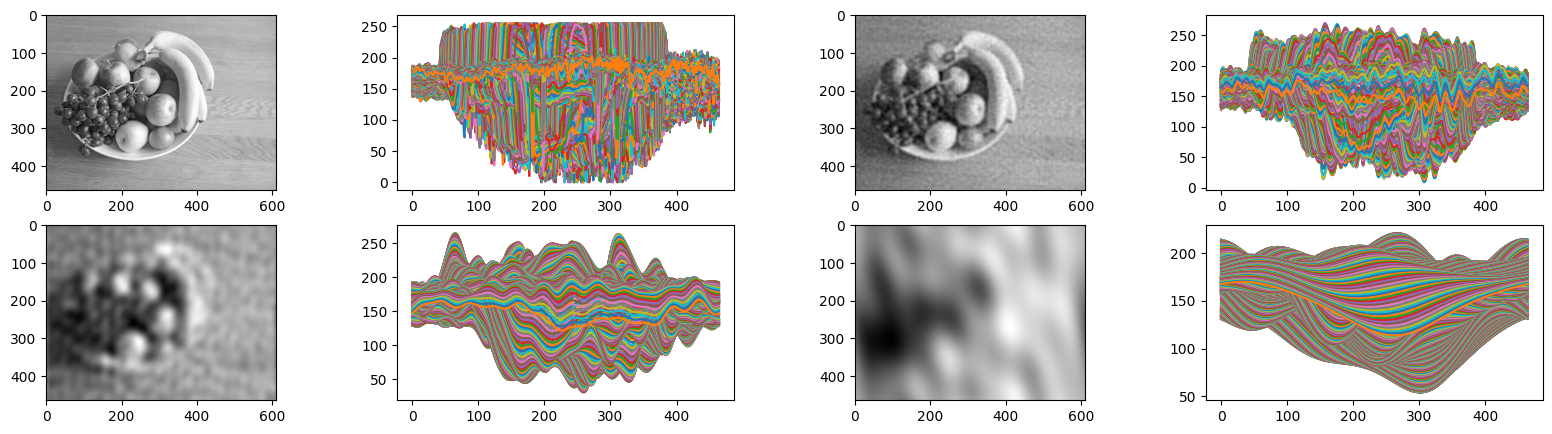

In [180]:
fig, ax = plt.subplots(2, 4, figsize=(20, 5))
ax[0, 0].imshow(image, cmap='gray')
ax[0, 1].plot(image)
ax[0, 2].imshow(filtro_passa(fraction=0.01, passa_alta=True), cmap='gray');
ax[0, 3].plot(filtro_passa(fraction=0.01, passa_alta=True));
ax[1, 0].imshow(filtro_passa(fraction=0.001, passa_alta=True), cmap='gray');
ax[1, 1].plot(filtro_passa(fraction=0.001, passa_alta=True));
ax[1, 2].imshow(filtro_passa(fraction=0.0001, passa_alta=True), cmap='gray');
ax[1, 3].plot(filtro_passa(fraction=0.0001, passa_alta=True));

Para conseguir notar alguma diferença precisamos ser extremos e colocar valores bem próximos de zero (o contrário do passa baixa que quando colocamos valores próximos de zero não vemos diferença). Certamente, eu testei para 0 e o resultado é decepcionante. No gráfico vemos uma reta e a imagem fica totalmente preta. 

### Questão 05

![Questão 05](questao_5.png)

### Questão 06

Inicialmente, eu tinha pensado em algo assim. Mas o raciocínio está incorreto, visto que eu mostro que um filtro que é uma convolução circular tem as propriedades. Porém, a questão quer que eu mostre que um filtro que tenha as propriedades (linear e invariante por translação) é uma convolução circular. Acabei não conseguindo provar de fato, até encontrei umas respostas, mas como eu não entendi, não vou colocar aqui e aceitar que não consegui fazer essa questão. 

![Concolução](convolucao.png)

### Questão 07

Nessa eu confesso que, sem a ajuda do Chat GPT não iria rolar. Mas eu fiz o possível para que fosse produtivo e que eu aprendesse algo pelo menos.

In [181]:
# lendo as imagens
g = cv2.imread('questao_07/gabarito.jpg', 0)
r = cv2.imread('questao_07/resposta.jpg', 0)

# transformada de fourier para mais de uma dimensão (por média da fft pelo que eu pude ler )
g_fft = np.fft.fft2(g)
r_fft = np.fft.fft2(r)

![Deslocamento do Spectro](deslocamento_de_spectro.png)

In [182]:
# encontra o deslocamento entre os espectros
shift = np.fft.fftshift(np.fft.ifft2(np.conj(g_fft) * r_fft))

![Coreção de fase](correcao_de_fase.png)

In [183]:
r_fft_corrigido = r_fft * np.exp(1j * np.angle(shift))

In [184]:
# aplica a transformação inversa, após corrigir a imagem das respostas (isso eu sabia de boa)
r_corrigido = np.fft.ifft2(r_fft_corrigido)
r_corrigido = np.real(r_corrigido)

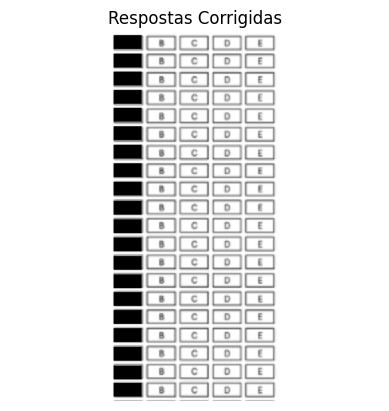

In [185]:
plt.imshow(np.abs(r_corrigido), cmap='gray')
plt.title('Respostas Corrigidas')
plt.axis('off')
plt.show()

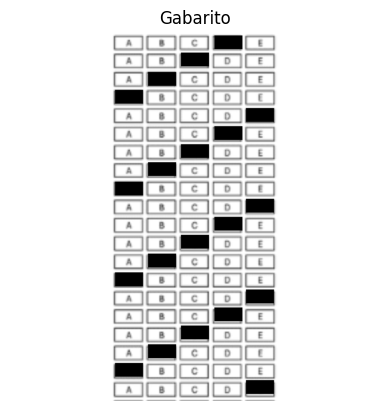

In [186]:
plt.imshow(np.abs(g), cmap='gray')
plt.title('Gabarito')
plt.axis('off')
plt.show()

In [187]:
pixels = np.sum(np.abs(g - r_corrigido) > 100)
print(f"Número de pixels diferentes (100 de tolerância): {pixels}")

Número de pixels diferentes (100 de tolerância): 108727


In [188]:
print(f"Dimensão da imagem do gabarito: {g.shape} - {g.shape[0]*g.shape[1]} pixels.")
print(f"Dimensão da imagem das respostas: {r_corrigido.shape} - {r_corrigido.shape[0]*r_corrigido.shape[1]} pixels.")

Dimensão da imagem do gabarito: (1080, 1080) - 1166400 pixels.
Dimensão da imagem das respostas: (1080, 1080) - 1166400 pixels.


A questão agora é descobrir quantos pixels tem cada "quadradinho" de resposta, para dividir por eles e estimar o número de acertos. Vou gerar outro cartão de respostas, agroa com 5 questões certas, realizar o mesmo procedinmento, ver quanto aumentou e fazer uma estimativa. 

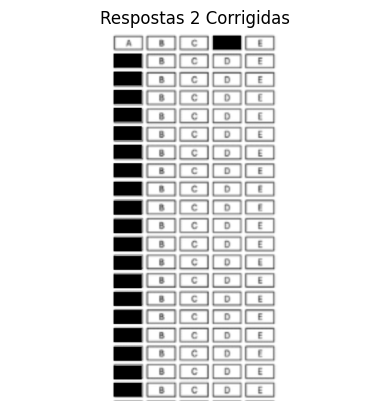

In [189]:
# lendo a imagem
r2 = cv2.imread('questao_07/resposta_2.jpg', 0)
# transformada de fourier
r2_fft = np.fft.fft2(r2)
# deslocamento de espectro
shift_r2 = np.fft.fftshift(np.fft.ifft2(np.conj(g_fft) * r2_fft))
# correcao de fase
r2_fft_corrigido = r2_fft * np.exp(1j * np.angle(shift_r2))
# transformada inversa
r2_corrigido = np.fft.ifft2(r2_fft_corrigido)
# retirando a parte complexa
r2_corrigido = np.real(r2_corrigido)
# plotando a imagem
plt.imshow(np.abs(r2_corrigido), cmap='gray')
plt.title('Respostas 2 Corrigidas')
plt.axis('off')
plt.show()

In [190]:
pixels_r2 = np.sum(np.abs(g - r2_corrigido) > 100)
print(f"Número de pixels diferentes (100 de tolerância): {pixels_r2}")

Número de pixels diferentes (100 de tolerância): 102528


Diminuiu algo em torno de 6 mil pixels. Vou estimar que esse seja o número de pixels de cada campo de resposta. Como são 20, em uma folha de resposta totalmente errada teremos 120 mil (mais uma tolerância) pixels. Logo, estamos "prontos" para calcular. Vamos fazer uma regressão linear bem porca, visto que não é esse o objetivo. No segundo teste, erramos 15 questões, logo teríamos que ter 90 mil pixels, mas temos 102 mil. No primeiro, erramos 16, era pra ter 96 mil, mas temos 108. Por isso, vamos supor que exista uma diferença fixa de 12 mil pixels sempre, mesmo que eu gabarite. 

In [191]:
def numero_de_acertos(path_respostas:str="questao_07/resposta.jpg") -> int:
    """
    Calcula o número de acertos comparando uma resposta de um aluno com um gabarito.

    Args:
        path_respostas (str): O caminho para o arquivo da imagem da resposta do aluno. 
                              O padrão é "resposta.jpg".

    Returns:
        int: O número de questões corretas, calculado com base na comparação da resposta do aluno com o gabarito.
    """
    # lendo a imagem
    resp = cv2.imread(path_respostas, 0)
    # transformada de fourier
    resp_fft = np.fft.fft2(resp)
    # deslocamento de espectro
    shift_resp = np.fft.fftshift(np.fft.ifft2(np.conj(g_fft) * resp_fft))
    # correcao de fase
    resp_fft_corrigido = resp_fft * np.exp(1j * np.angle(shift_resp))
    # transformada inversa
    resp_corrigido = np.fft.ifft2(resp_fft_corrigido)
    # retirando a parte complexa
    resp_corrigido = np.real(resp_corrigido)
    # calculo do número de acertos
    pixels_resp = np.sum(np.abs(g - resp_corrigido) > 100)
    # aqui estou com as medidas exatas (acima eu tinha falado 12 mil fixos e 6 mil variáveis, mas era um arredondamento)
    acertos = 20 - int((pixels_resp - 9543)/6199)
    

    return acertos

In [192]:
from colorama import Fore

for i in range(0, 21):
    if i == 4:
        n_acertos = numero_de_acertos()
    elif i == 5:
        n_acertos = numero_de_acertos("questao_07/resposta_2.jpg")
    elif i == 20:
        n_acertos = numero_de_acertos("questao_07/gabarito.jpg")
    else: 
        n_acertos = numero_de_acertos(f"questao_07/resposta_{i}_acertos.jpg")
    
    if n_acertos != i:
        print(Fore.RED + f"Número de acertos: {i} - Número de Acertos Previstos: {n_acertos}")
    else:
        print(Fore.GREEN + f"Número de acertos: {i} - Número de Acertos Previstos: {n_acertos}")

Número de acertos: 0 - Número de Acertos Previstos: 1
Número de acertos: 1 - Número de Acertos Previstos: 2
Número de acertos: 2 - Número de Acertos Previstos: 3
Número de acertos: 3 - Número de Acertos Previstos: 3
Número de acertos: 4 - Número de Acertos Previstos: 4
Número de acertos: 5 - Número de Acertos Previstos: 5
Número de acertos: 6 - Número de Acertos Previstos: 6
Número de acertos: 7 - Número de Acertos Previstos: 7
Número de acertos: 8 - Número de Acertos Previstos: 8
Número de acertos: 9 - Número de Acertos Previstos: 9
Número de acertos: 10 - Número de Acertos Previstos: 10
Número de acertos: 11 - Número de Acertos Previstos: 11
Número de acertos: 12 - Número de Acertos Previstos: 12
Número de acertos: 13 - Número de Acertos Previstos: 13
Número de acertos: 14 - Número de Acertos Previstos: 14
Número de acertos: 15 - Número de Acertos Previstos: 15
Número de acertos: 16 - Número de Acertos Previstos: 16
Número de acertos: 17 - Número de Acertos Previstos: 16
Número de ac

Alguns comentários podem ser feitos após os testes. Primeiro, que a regressão feita não foi boa. Pelo comportamento ruim nas extremidades, imagino que um modelo polinomial do segundo grau seja o mais adequado, mas isso é apenas uma intuição. Segundo, que embora eu tenha mantido a tolerância (um hiperparâmetros) como 100, se eu diminuísse para 90 o modelo funcionaria melhor (ganharia mais um acerto). Porém, fiquei satisfeito com o resultado.